Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r"/content/gdrive/MyDrive/CNN/Assignment/Train")
data_dir_test = pathlib.Path(r"/content/gdrive/MyDrive/CNN/Assignment/Test")

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    subset = 'training',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    subset = 'validation',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

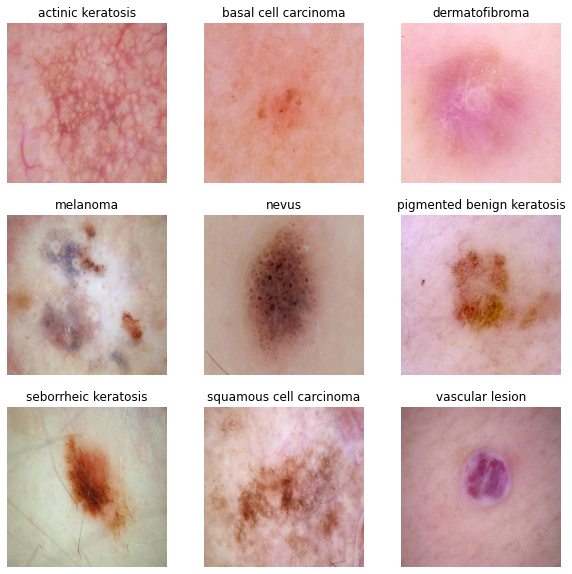

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
i=0
for k in class_names:
  for img, labels in train_ds.unbatch().take(1792):
    if class_names[labels] == k:
      i=i+1
      ax = plt.subplot(3, 3, i)
      plt.imshow(img.numpy().astype("uint8"))
      plt.title(class_names[labels])
      plt.axis("off")
      break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
n_class = 9

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_width,img_height,3)),

  layers.Conv2D(16, 3, padding = 'same',activation='relu'),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(32, 3,padding = 'same', activation='relu'),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(64, 3,padding = 'same', activation='relu'),
  layers.Conv2D(64, 3,padding = 'same', activation='relu'),
  layers.MaxPooling2D((2, 2)),

  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(n_class, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 64)        3

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


56/56 [==============================] - 309s 1s/step - loss: 2.0767 - accuracy: 0.2299 - val_loss: 1.9006 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.8460 - accuracy: 0.3119 - val_loss: 1.7780 - val_accuracy: 0.4027
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.7426 - accuracy: 0.3728 - val_loss: 1.6546 - val_accuracy: 0.3826
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5854 - accuracy: 0.4420 - val_loss: 1.6413 - val_accuracy: 0.4206
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4488 - accuracy: 0.4994 - val_loss: 1.4588 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3845 - accuracy: 0.5206 - val_loss: 1.4563 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3138 - accuracy: 0.5385 - val_loss: 1.4384 - val_accuracy: 0.5213
Epoch 8/20
56/56 [======

### Visualizing training results

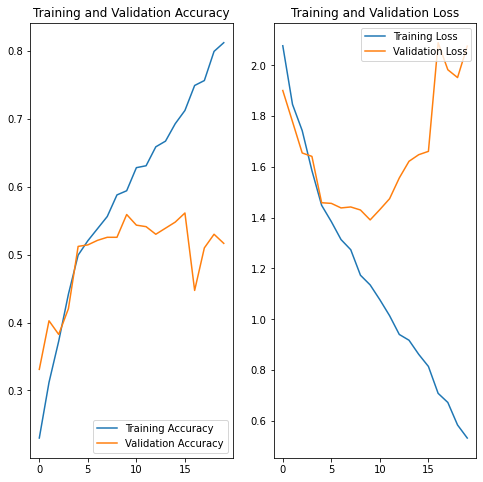

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

No matter the architecture of the network (no of layers, noof neurons in layers, dropout etc), model is overfitting.
the overfitting can be observed from the graph as well as the difference in the validation and training accuracies of the network trained. [Training accuracy ~89%, validation accuracy ~53%]
The overfitting can occure generally due to smaller chunk of input data where the model learns from noisy details.
Data Augmentation helps in such cases. Data augmentation is basically adding more data by performing simple operations on the existing data.

### Write your findings here

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
augment_data = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

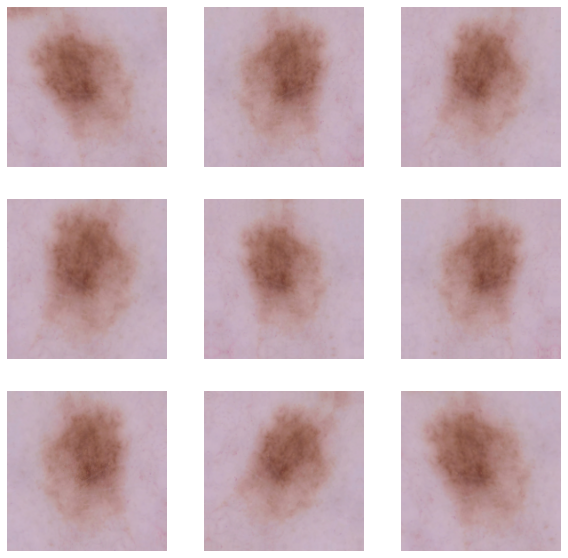

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = augment_data(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[1].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  augment_data,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(n_class, activation= 'softmax')
])



### Compiling the model

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


56/56 [==============================] - 3s 32ms/step - loss: 2.0865 - accuracy: 0.2282 - val_loss: 1.9155 - val_accuracy: 0.2864
Epoch 2/20
56/56 [==============================] - 2s 27ms/step - loss: 1.9249 - accuracy: 0.2729 - val_loss: 1.7569 - val_accuracy: 0.3535
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.6807 - accuracy: 0.4096 - val_loss: 1.5210 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5127 - accuracy: 0.4570 - val_loss: 1.5039 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 1s 27ms/step - loss: 1.4920 - accuracy: 0.4721 - val_loss: 1.8293 - val_accuracy: 0.3647
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4636 - accuracy: 0.4978 - val_loss: 1.4178 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4241 - accuracy: 0.4978 - val_loss: 1.4437 - val_accuracy: 0.4810
Epoch 8/20
56/56 [======

### Visualizing the results

Text(0.5, 1.0, 'Training and Validation Loss')

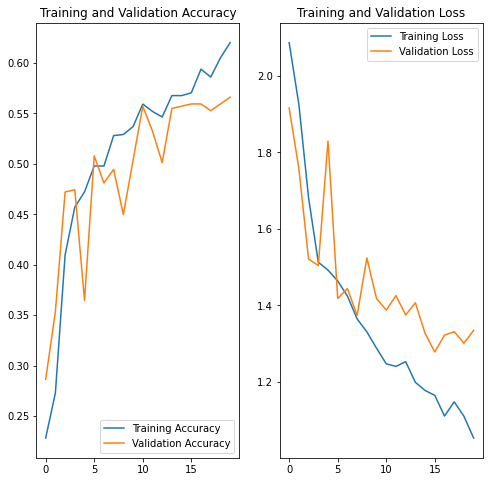

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The oveerfitting has decreased significantly by using data augmentation.
It can be observed from the graphs above that the training and validation curves in both loss and accuracy are close to each other and are consistently moving. [Training accuracy ~60%, validation accuracy ~54%]
Also it can be observed from the model training that there is no significant improvement in the validation accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

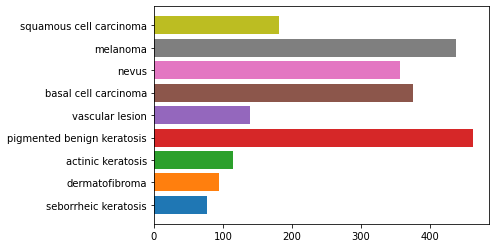

In [27]:
import os
path = '/content/gdrive/MyDrive/CNN/Assignment/Train'
mn = 0
folders = ([name for name in os.listdir(path)
            if os.path.isdir(os.path.join(path, name))]) # get all directories 
for folder in folders:
    contents = os.listdir(os.path.join(path,folder)) # get list of contents
    if len(contents) >= mn: # if greater than the limit, print folder and number of contents
        plt.barh(folder,len(contents))

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

seborrheic keratosis


#### - Which classes dominate the data in terms proportionate number of samples?

"pigmented benign keratosis", "melanoma", "basal cell carcinoma", "nevus" (Decreasing order)


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset= '/content/gdrive/MyDrive/CNN/Assignment/Train/'
import Augmentor
for i in class_names:
  p = Augmentor.Pipeline(path_to_training_dataset + i)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD31C0C7910>: 100%|██████████| 500/500 [00:21<00:00, 23.17 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD316591F90>: 100%|██████████| 500/500 [00:21<00:00, 22.73 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD31C0EA5D0>: 100%|██████████| 500/500 [00:23<00:00, 21.60 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7FD31C03DE50>: 100%|██████████| 500/500 [01:46<00:00,  4.69 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD31D842410>: 100%|██████████| 500/500 [01:26<00:00,  5.80 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD31C0C5350>: 100%|██████████| 500/500 [00:22<00:00, 22.12 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD31C160CD0>: 100%|██████████| 500/500 [00:49<00:00, 10.15 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3165916D0>: 100%|██████████| 500/500 [00:22<00:00, 22.55 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD31C1B4CD0>: 100%|██████████| 500/500 [00:21<00:00, 23.57 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
import glob

In [37]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN/Assignment/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011077.jpg_f1657132-b530-411b-8f6d-39176244c2f1.jpg',
 '/content/gdrive/MyDrive/CNN/Assignment/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010862.jpg_ab8442ef-fc00-4e72-96d7-eef8743323a1.jpg',
 '/content/gdrive/MyDrive/CNN/Assignment/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010872.jpg_8ee1e7cb-153f-4457-9a22-fc4988d492d1.jpg',
 '/content/gdrive/MyDrive/CNN/Assignment/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010993.jpg_8b983c86-7cc4-43e2-b3f8-878e18e34075.jpg',
 '/content/gdrive/MyDrive/CNN/Assignment/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011187.jpg_37400967-6f6b-42ea-ae1b-dfc9d37ab20f.jpg',
 '/content/gdrive/MyDrive/CNN/Assignment/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011169.jpg_2af52775-d1bf-466d-a868-ff5ff5c14e75.jpg',
 '/content

In [38]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [39]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [40]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesson_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesson_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [41]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [43]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = 'training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [45]:
n_class = 9

model = Sequential([
  augment_data,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(n_class, activation= 'softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [46]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

#### **Todo:**  Train your model

In [47]:
epochs = 30
history = history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


169/169 [==============================] - 39s 216ms/step - loss: 1.8720 - accuracy: 0.2719 - val_loss: 1.5876 - val_accuracy: 0.3512
Epoch 2/30
169/169 [==============================] - 37s 214ms/step - loss: 1.4793 - accuracy: 0.4314 - val_loss: 1.6016 - val_accuracy: 0.4091
Epoch 3/30
169/169 [==============================] - 37s 212ms/step - loss: 1.3859 - accuracy: 0.4763 - val_loss: 1.3131 - val_accuracy: 0.5048
Epoch 4/30
169/169 [==============================] - 37s 212ms/step - loss: 1.2789 - accuracy: 0.5122 - val_loss: 1.3586 - val_accuracy: 0.4967
Epoch 5/30
169/169 [==============================] - 36s 207ms/step - loss: 1.2339 - accuracy: 0.5299 - val_loss: 1.3091 - val_accuracy: 0.5115
Epoch 6/30
169/169 [==============================] - 36s 210ms/step - loss: 1.1983 - accuracy: 0.5382 - val_loss: 1.2262 - val_accuracy: 0.5412
Epoch 7/30
169/169 [==============================] - 36s 209ms/step - loss: 1.1010 - accuracy: 0.5721 - val_loss: 1.1712 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

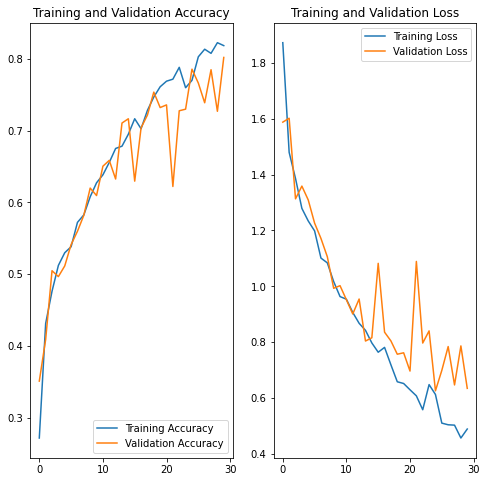

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The above results in graph and training data indicate that the accuracy has improved and that there is no overfitting of the model.[Training accuracy ~81%, validation accuracy ~79%]

Using augmentation helped in solving the issue of underfitting.

While using the class balancing, the accuracy of the model has improved significantly. So, it definitely helped.

Using both resulted in a much efficient model.

Also the results varied over multiple runs. There were instances with approximately 79-80% validation accuracy too. So, I'd say an average validation accuracy of 77% for this model.

​